# Описание проекта

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Разделим наши работу на несколько этапов:

* Получение общей информации из исходного файла.


* Предобработка данных.
    * Преобразование данных к нужным типам
    * Исправление ошибок в данных
    * Расчёт требуемых характеристик 


* Проверка сформулированных гипотез


* Общий вывод

In [337]:
import pandas as pd
import numpy as np
import math as mt
from scipy import stats as st
import seaborn as sns

# Шаг 1. Открываем общий файл и изучаем общую информацию.

In [338]:
df_calls = pd.read_csv('/datasets/calls.csv')
df_internet = pd.read_csv('/datasets/internet.csv')
df_messages = pd.read_csv('/datasets/messages.csv')
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_users = pd.read_csv('/datasets/users.csv')

In [339]:
names= [df_calls, df_internet, df_messages, df_tariffs, df_users]
for i in range(len(names)):
    names[i].info()
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB

<class 'pandas.core.frame.DataFrame'>
R

### Итог:

Таблица *users* (информация о пользователях):

* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя*
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана)

Таблица calls (информация о звонках):
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

# Шаг 2. Предобработка данных.

#### Рассмотрим таблицу df_calls

In [340]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [341]:
df_calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


Значения call_date переведём в тип datetime. Предположим, что звонки длительностью 0.0 минут - пропущенные звонки. Будем учитывать их в качестве совершённых, но не учитывать в суммировании продолжительностей звонков в последующем.

In [342]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


#### Рассмотрим таблицу df_internet

In [343]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [344]:
df_internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


Заметим столбец Unnamed: 0. Похоже на на техническую ошибку.
Преобразуем значения session_date в тип datetime

#### Исправим техническую ошибку

In [345]:
df_internet = df_internet[['id', 'mb_used', 'session_date', 'user_id']]

In [346]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [347]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


#### Рассмотрим таблицу df_messages

In [348]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [349]:
df_messages.sample(5)

,id,message_date,user_id
44674,1196_124,2018-11-19,1196
66439,1284_27,2018-08-02,1284
80400,1335_312,2018-10-22,1335
88098,1369_23,2018-09-05,1369
110627,1448_96,2018-10-13,1448


Преобразуем столбец message_date в формат datetime.

In [350]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


#### Рассмотрим таблицу df_users

In [351]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Видим пропуски в столбце churn_date. Не будем ничего изменять, т.к. этот столбец нам не нужен для анализа. Преобразуем значения reg_date в формат datetime.

In [352]:
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'])
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'])
df_users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


#### Рассмотрим таблицу df_tariffs

In [353]:
df_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [354]:
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Добавим столбец *month* в таблицы df_intnternet, df_calls, df_messages, отображающий месяц, в котором выполнено действие.

#### Преобразуем к нужным типам.

In [355]:
df_internet['month'] = df_internet['session_date'].dt.month
df_calls['month'] = df_calls['call_date'].dt.month
df_messages['month'] = df_messages['message_date'].dt.month

In [356]:
df_calls['duration'] = df_calls['duration'].apply(np.ceil)
df_internet['mb_used'] = df_internet['mb_used'].apply(np.ceil)

#### Вычислим количество сделанных звонков и израсходованных минут разговора по месяцам.

Сформируем группу звонков по *user_id* и *month*

In [357]:
df_calls_group = df_calls.pivot_table(index=['user_id', 'month'], 
                                      values=['duration', 'id'], 
                                      aggfunc={'duration':'sum', 'id':'count'})

df_calls_group.columns = ['duration_sum', 'calls_count']
#df_calls_group = df_calls_group.reset_index()
df_calls_group

duration_sum  calls_count
user_id month                           
1000    5             159.0           22
        6             172.0           43
        7             340.0           47
        8             408.0           52
        9             466.0           58
...                     ...          ...
1498    10            247.0           41
1499    9              70.0            9
        10            449.0           68
        11            612.0           74
        12            492.0           69

[3174 rows x 2 columns]

**Вычислим количество отправленных сообщений по месяцам**

Сформируем группу сообщений по *user_id* и *month*

In [358]:
df_messages_group = df_messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc={'count'})
df_messages_group.columns = ['messages_count']
df_messages_group

messages_count
user_id month                
1000    5                  22
        6                  60
        7                  75
        8                  81
        9                  57
...                       ...
1498    10                 42
1499    9                  11
        10                 48
        11                 59
        12                 66

[2717 rows x 1 columns]

**Вычислим объем израсходованного интернет-трафика по месяцам**

Сформируем группу трафика по *user_id* и *month*

In [359]:
df_internet_group = df_internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc={'sum'})
df_internet_group.columns = ['mb_used_sum']
df_internet_group

mb_used_sum
user_id month             
1000    5           2256.0
        6          23257.0
        7          14016.0
        8          14070.0
        9          14581.0
...                    ...
1498    10         20604.0
1499    9           1848.0
        10         17809.0
        11         17984.0
        12         13077.0

[3203 rows x 1 columns]

**Вычислим помесячную выручку с каждого пользователя**

Напишем функцию расчитывающую выручку с каждого пользователя.

In [360]:
def proceeds(users_info):
    messages_income = (users_info['messages_count'] - users_info['messages_included'].astype('int64'))*users_info['rub_per_message']
    mb_income = ((users_info['mb_used_sum'] - users_info['mb_per_month_included'].apply(np.ceil).astype('int64'))/1024).apply(np.ceil)*users_info['rub_per_gb']
    calls_income = (users_info['duration_sum'] - users_info['minutes_included'].apply(np.ceil).astype('int64'))*users_info['rub_per_minute']

    messages_income = messages_income.where(messages_income > 0, 0)
    mb_income = mb_income.where(mb_income > 0, 0)
    calls_income = calls_income.where(calls_income > 0, 0)

    users_info['income'] = (users_info['rub_monthly_fee'] + messages_income + mb_income + calls_income).astype('int64')
    
    return users_info[['user_id', 'month', 'city', 'tariff', 'rub_monthly_fee', 'income']]

*users_info* содержит полную  информацию о пользователе: количество звонков, их продолжительность, объем трафика и количество сообщений сгруппированную по месяцам.

In [361]:
users_info = df_calls_group.merge(df_messages_group, on=['user_id', 'month'], how='outer')
users_info = users_info.merge(df_internet_group, on=['user_id', 'month'], how='outer')
users_info = users_info.reset_index()
users_info = df_users.merge(users_info, on='user_id', how='outer')
df_tariffs.columns = ['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff']

users_info = users_info.merge(df_tariffs, on='tariff', how='outer')

df_proceeds = proceeds(users_info)
df_proceeds

,user_id,month,city,tariff,rub_monthly_fee,income
0,1000,5.0,Краснодар,ultra,1950,1950
1,1000,6.0,Краснодар,ultra,1950,1950
2,1000,7.0,Краснодар,ultra,1950,1950
3,1000,8.0,Краснодар,ultra,1950,1950
4,1000,9.0,Краснодар,ultra,1950,1950
...,...,...,...,...,...,...
3211,1498,10.0,Владикавказ,smart,550,1750
3212,1499,9.0,Пермь,smart,550,550
3213,1499,10.0,Пермь,smart,550,1150
3214,1499,11.0,Пермь,smart,550,1513


In [362]:
users_info['mb_used_sum'].sum(), df_internet['mb_used'].sum()

(55369459.0, 55369459.0)

### Итог:

Обнаружили ошибку в таблице df_internet: лишний столбец Unnamed 0. В каждой таблице преобразовали значение даты к формату datetime, добавили столбцы *month*.

Вычислили количество сделанных звонков и израсходованных минут разговора по месяцам в таблице *df_calls_group*

Вычислили количество отправленных сообщений по месяцам в таблице *df_messages_group*

Вычислили объем израсходованного интернет-трафика по месяцам в таблице *df_internet_group*

Вычислили помесячную выручку с каждого пользователя в таблице *df_proceeds*

# Шаг 3. Анализ данных.

In [363]:
users_info

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,duration_sum,...,messages_count,mb_used_sum,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,income
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,159.0,...,22.0,2256.0,1000,30720,3000,1950,150,1,1,1950
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,172.0,...,60.0,23257.0,1000,30720,3000,1950,150,1,1,1950
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,340.0,...,75.0,14016.0,1000,30720,3000,1950,150,1,1,1950
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,408.0,...,81.0,14070.0,1000,30720,3000,1950,150,1,1,1950
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,466.0,...,57.0,14581.0,1000,30720,3000,1950,150,1,1,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,10.0,247.0,...,42.0,20604.0,50,15360,500,550,200,3,3,1750
3212,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,9.0,70.0,...,11.0,1848.0,50,15360,500,550,200,3,3,550
3213,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,10.0,449.0,...,48.0,17809.0,50,15360,500,550,200,3,3,1150
3214,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,11.0,612.0,...,59.0,17984.0,50,15360,500,550,200,3,3,1513


Напишем функцию *stat* формирующую графики расхода трафика, количества сообщений и продолжительности звонков по месяцам, а также вычисляющую такие характеристики выборки как среднее, дисперсия и стандартное отклонение в зависимости от тарифа

In [364]:
def stat(x):
    columns = ['mb_used_sum', 'duration_sum', 'messages_count']
    titles = ['mb_used', 'duration_calls', 'messages_count']
    yset = ['mb', 'sec', 'count']
    for i in range(len(columns)):
        ultra = x[x['tariff']=='ultra'].pivot_table(index='month', values=columns[i], aggfunc={'mean'})
        smart = x[x['tariff']=='smart'].pivot_table(index='month', values=columns[i], aggfunc={'mean'})
        ax = ultra.plot(kind='bar')
        bx = smart.plot(kind='bar', ax=ax, color='orange', title=titles[i], alpha=0.9)
        bx.legend(['ultra', 'smart'])
        bx.set_ylabel(yset[i])
    
    x = x.pivot_table(index='tariff', values=['mb_used_sum', 'duration_sum', 'messages_count'], aggfunc={'mean', 'var', 'std'})
    x = x.apply(np.ceil, axis=1)
    return x

duration_sum                 mb_used_sum                      \
               mean    std      var        mean     std         var   
tariff                                                                
smart         420.0  190.0  35845.0     16237.0  5869.0  34443101.0   
ultra         546.0  307.0  94204.0     19687.0  9953.0  99043440.0   

       messages_count                
                 mean   std     var  
tariff                               
smart            39.0  27.0   718.0  
ultra            62.0  46.0  2110.0

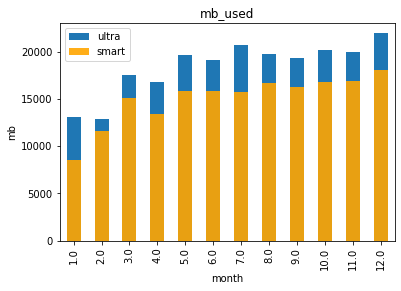

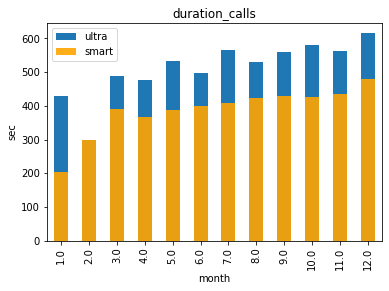

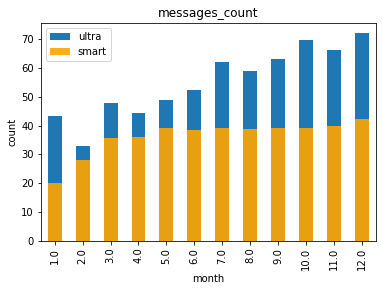

In [365]:
stat(users_info)

Обратим внимание на то, что во 2 месяце, т.е. в феврале, расходы пользователей разных тарифов схожи, а по количеству потраченных звонков почти сравнялись.

Напишем функцию *sns_stat*, строющую график плотности распределения и показывающую основные характеристики выборки: среднее, медиана, стандартное отклонение и т.д.

In [366]:
def sns_sts(s):
    sns_plot = sns.distplot(users_info[users_info['tariff']=='ultra'][s].dropna())
    ax = sns.distplot(users_info[users_info['tariff']=='smart'][s].dropna(), ax = sns_plot, color='orange')
    ax.legend(['ultra', 'smart'])
    ax.set_title(s)
    print('ultra:\n', users_info[users_info['tariff']=='ultra'][s].dropna().describe())
    print()
    print('smart:\n', users_info[users_info['tariff']=='smart'][s].dropna().describe())
    
    return

**Рассмотрим подробнее количество отправленных сообщений**

ultra:
 count    795.000000
mean      61.161006
std       45.931026
min        1.000000
25%       24.000000
50%       51.000000
75%       87.500000
max      224.000000
Name: messages_count, dtype: float64

smart:
 count    1922.000000
mean       38.716441
std        26.787949
min         1.000000
25%        17.000000
50%        34.000000
75%        55.000000
max       143.000000
Name: messages_count, dtype: float64


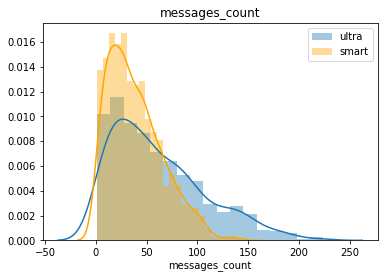

In [367]:
sns_stat('messages_count')

Обратим внимание на то, что наибольшая плотность распределения для 2х тарифов находится на схожем интервале, однако, распределение пользователей тарифа SMART более блотно в этой области, в отличие от распределения пользователей тарифа ULTRA, которое более равномерно. Предполагаем, что это связано с большим бесплатным лимитом и меньшим количеством пользователей тарифа ULTRA.

**Рассмотрим подробнее продолжительность звонка**

ultra:
 count     951.000000
mean      545.451104
std       306.925754
min         0.000000
25%       310.000000
50%       528.000000
75%       756.500000
max      1673.000000
Name: duration_sum, dtype: float64

smart:
 count    2223.000000
mean      419.062978
std       189.325618
min         0.000000
25%       285.000000
50%       423.000000
75%       545.500000
max      1435.000000
Name: duration_sum, dtype: float64


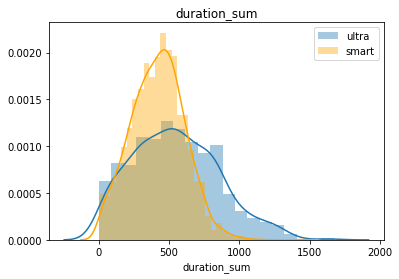

In [368]:
sns_stat('duration_sum')

Аналогично можем сделать вывод, что наибольшая плотность распределения находится на схожем интервале. Однако прослеживается резкий спад для тарифа SMART ввиду низкого лимита относительно тарифа ULTRA

**Рассмотрим подробнее количество потраченного интернет-трафика**

ultra:
 count      975.000000
mean     19686.767179
std       9952.057054
min          0.000000
25%      12020.500000
50%      19411.000000
75%      26920.500000
max      49789.000000
Name: mb_used_sum, dtype: float64

smart:
 count     2228.000000
mean     16236.472621
std       5868.824472
min          0.000000
25%      12668.500000
50%      16532.000000
75%      20068.000000
max      38610.000000
Name: mb_used_sum, dtype: float64


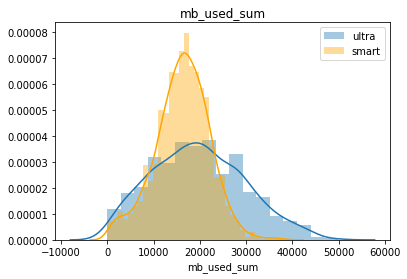

In [369]:
sns_sts('mb_used_sum')

Исходя из построенных графиков можем предположить, что основные потребности пользователей покрывают оба тарифа, т.к. зоны наибольшей плотности распределения схожи. Наиболее схожа ситуация для количества отправленных сообщений, скорее всего т.к. люди редко их отправляют, интернет-мессенджеры более актуальны. Хуже ситуация с инернетом, для тарифа SMART лимит заметно ближе к основной потребности, от этого получаем резкий спад.

### Итог:

Видим динамику роста таких параметров как количество отправленных сообщений, количество потраченного интернет-трафика в течении года.

Обратим внимание на то, что пользователи тарифа ULTRA более активны в начале года по сравнению с SMART, особенно это выражено в количестве отправленных сообщений и минутах разговора. Также отметим малое изменение количества отправленных сообщений начиная с мая для тарифа SMART.

Обратим внимание на то, что разница в использованном трафике интернета между тарифами мала, относительно разниц в звонках и сообщениях.

# Шаг 4. Проверка гипотез.

Прежде чем использовать Т-критерий Стьюдента проверим гипотезу о равенстве дисперсий выборок.
Воспользуемся тестом Левене. Нулевая гипотеза состоит в том, что дисперсии выборок равны. Альтернативная гипотеза предполагает обратное: дисперсии не равны.

In [370]:
ultra_income = df_proceeds[df_proceeds['tariff']=='ultra']['income']
smart_income = df_proceeds[df_proceeds['tariff']=='smart']['income']

results = st.levene(ultra_income, smart_income)
print('pvalue -', results.pvalue)

pvalue - 1.493529889772582e-124


Значение pvalue очень мало, а значит нулевая гипотеза отвергается, т.е. дисперсии выборок различны, а значит параметру *equal_var* в методе *ttest_ind* назначим False

Проверим следующую гипотезу: средняя выручка пользователей тарифов «Ультра» и «Смарт» равна, возьмём ее в качестве нулевой. В качестве альтернативной гипотезы возьмём предположение о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» всё же различна.

В качестве параметра alpha возьмём 0.05

In [371]:
ultra_income = df_proceeds[df_proceeds['tariff']=='ultra']['income']
smart_income = df_proceeds[df_proceeds['tariff']=='smart']['income']

alpha = 0.05

results = st.ttest_ind(ultra_income, smart_income, equal_var=False)

print('pvalue -', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

pvalue - 1.2414049931248708e-246
Отвергаем нулевую гипотезу


In [372]:
print('ULTRA', ultra_income.mean())
print('SMART', smart_income.mean())

ULTRA 2070.943204868154
SMART 1294.3053811659192


Результат говорит о том, что выручка пользователей разных тарифов различается и вероятнее с тарифа ULTRA выручка больше.

Проверим ледующую гипотезу: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов. Возьмём её в качестве нулевой. В качестве параметра alpha возьмём 0.05

In [373]:
moscow_income = df_proceeds[df_proceeds['city']=='Москва']['income']
another_income = df_proceeds[df_proceeds['city']!='Москва']['income']

alpha = 0.05

results = st.ttest_ind(moscow_income, another_income, equal_var=False)

print('pvalue -', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

pvalue - 0.5086199993481282
Не получилось отвергнуть нулевую гипотезу


In [374]:
print('Москва - ', moscow_income.mean())
print('Другие регионы - ', another_income.mean())

Москва -  1550.8052373158755
Другие регионы -  1528.1032629558542


Результат говорит о том, что мы не можем отвергать предположение о том, что средняя выручка пользователей из Москвы и других регионов не отличается

### Итог:

Наше исследование показало, что выручка пользователей зависит от тарифа, причем вероятнее при тарифе ULTRA выручка больше.
По исходным данным на тарифе ULTRA выручка составила - 2048 на пользователя в месяц.
В то время как на SMART - 1257

Также исследование показало, что у нас нет оснований делать вывод о том, что выручка зависит от города.
По исходным данным в Москве выручка - 1536 на пользователя в месяц.
В других регионах - 1467

# Шаг 5. Общий вывод.

Обнаружили динамику роста таких параметров как количество отправленных сообщений, количество потраченного интернет-трафика в течении года.

Пользователи тарифа ULTRA более активны в начале года по сравнению с SMART, особенно это выражено в количестве отправленных сообщений и минутах разговора. Также отметим малое изменение количества отправленных сообщений начиная с мая для тарифа SMART.
Рразница в использованном трафике интернета между тарифами мала, относительно разниц в звонках и сообщениях.

Согласно результатам нашего исследования получили, что выручка пользователей зависит от тарифа, причем вероятнее при тарифе ULTRA выручка больше.

По исходным данным на тарифе ULTRA выручка составила - 2048 на пользователя в месяц.
В то время как на SMART - 1257

Также согласно результатам, у нас нет оснований делать вывод о том, что выручка зависит от города.

По исходным данным в Москве выручка - 1536 на пользователя в месяц.
В других регионах - 1467